# 0001 - Object tracking and transformation
---
**09.11.2020**

## Imports

In [25]:
import sys 
import numpy as np
import matplotlib.pyplot as plt
import cv2

from typing import Tuple
from PIL import Image

In [17]:
sys.path.append("../")

In [18]:
from src.pipeline.nodes import InferenceEngine, ObjectTracker, ViewTransformer
from src.sources.video import VideoSource
from src.utils.draw import draw_bounding_box, notebook_plot
from src.entities import BoundingBox

## Settings

In [19]:
VIDEO_SOURCE = '../data/videos/video_01.mp4'
TRACKED_CLASSES = ['car']

SOURCE_ROI = [
    [183., 171.],
    [595., 188.],
    [1615., 700.],
    [66., 570.]
]

TARGET_WIDTH = 100
TARGET_HEIGHT = 300

TARGET_ROI = [
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1]
]

PADDING = 20

## Load pipeline nodes

In [20]:
# video source
source = VideoSource(input_file=VIDEO_SOURCE)
# inference engine
engine = InferenceEngine(class_names=TRACKED_CLASSES)
# object tracker
tracker = ObjectTracker.initialize()
# view transformer
transformer = ViewTransformer.initialize(source=SOURCE_ROI, target=TARGET_ROI)


                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Focus                     [3, 32, 3]                    
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     19904  models.common.BottleneckCSP             [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  1    161152  models.common.BottleneckCSP             [128, 128, 3]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  1    641792  models.common.BottleneckCSP             [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  1    656896  


Fusing layers... 


Model Summary: 140 layers, 7.45958e+06 parameters, 7.45958e+06 gradients


Adding autoShape... 


## Load sample frame

In [21]:
frame = next(source.generate_frames())

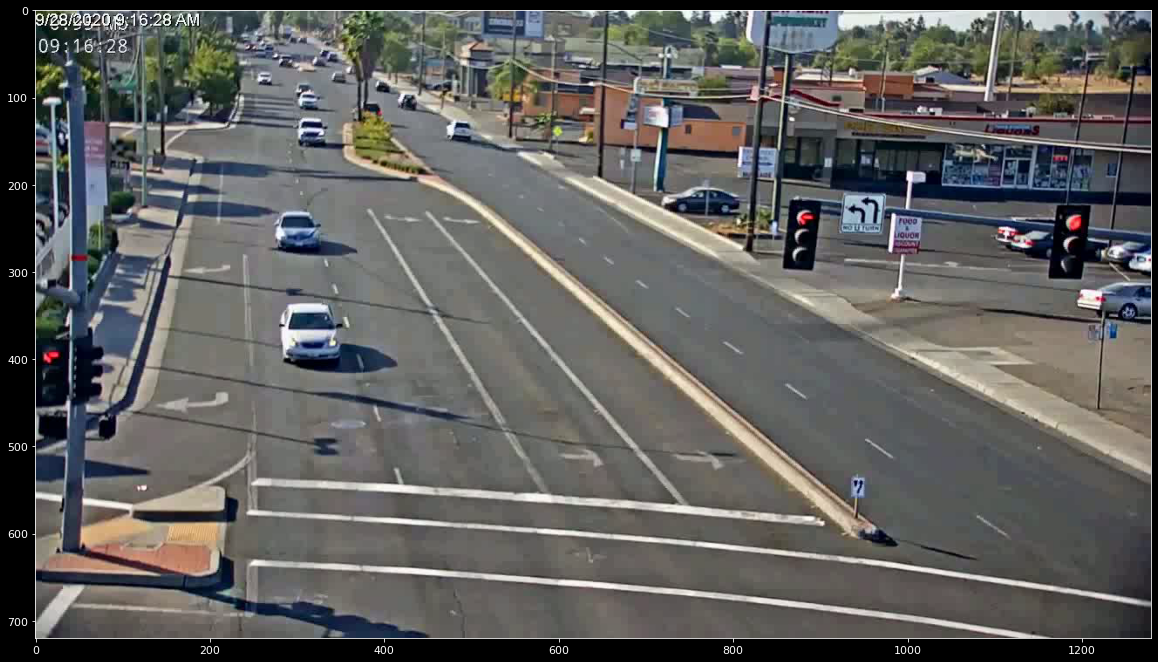

In [22]:
notebook_plot(frame.image)

In [26]:
cv2.imwrite("raw_frame.png", frame.image)

True

In [27]:
transformed_frame = transformer.transform_image(image=frame.image, width=TARGET_WIDTH, height=TARGET_HEIGHT)

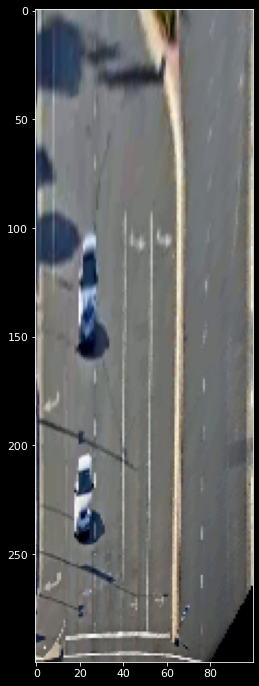

In [28]:
notebook_plot(transformed_frame, size=(12, 12))

In [36]:
cv2.imwrite("transformed_frame.png", transformed_frame)

True

## Detect objects single frame

In [30]:
objects = engine.infer(image=frame.image)

In [31]:
tracker.submit_frame(objects=objects)
tracked_objects = tracker.objects

[     22.833         157]
[     20.831      243.55]
[     35.886     -56.821]
[      43.67     -238.24]
[     89.015     -102.55]
[     140.49         184]
[     28.313     -455.94]


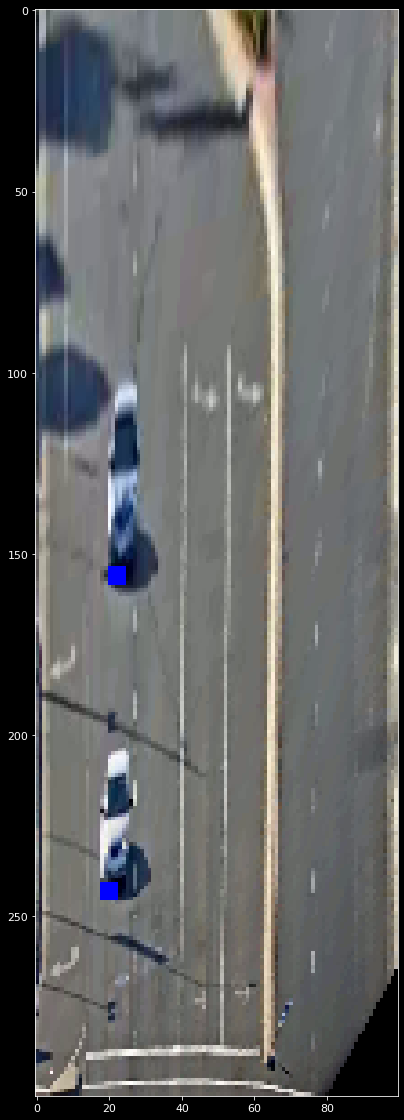

In [32]:
image = np.copy(transformed_frame)
for object_idx, object_data in tracked_objects.items():
    anchor = transformer.transform_point(object_data.bounding_box.anchor)
    print(anchor)
    image = draw_bounding_box(
        image=image, 
        bounding_box=BoundingBox(x0=anchor[0] - 2, y0=anchor[1] - 2, x1=anchor[0] + 2, y1=anchor[1] + 2), 
        thickness=-1,
        color=(255, 0, 0)
    )
notebook_plot(image=image)

## 3D Visualization

In [33]:
def create_blank_chart_with_styling(
    x_range: Tuple[int, int], 
    y_range: Tuple[int, int], 
    z_range: Tuple[int, int], 
    size: Tuple[int, int]
):
    # my favorite styling kit
    plt.style.use('dark_background')
    # determining the size of the graph
    fig = plt.figure(figsize=size)
    # 3D mode
    ax = fig.gca(projection='3d')
    # transparent axis pane background 
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    # setting chart axis names
    ax.set_xlabel("X Axis")
    ax.set_ylabel("Y Axis")
    ax.set_zlabel("Z Axis")
    
    ax.set_xlim3d(*x_range)
    ax.set_ylim3d(*y_range)
    ax.set_zlim3d(*z_range)
    ax.set_box_aspect([1,3,0.25])
    return (fig, ax)


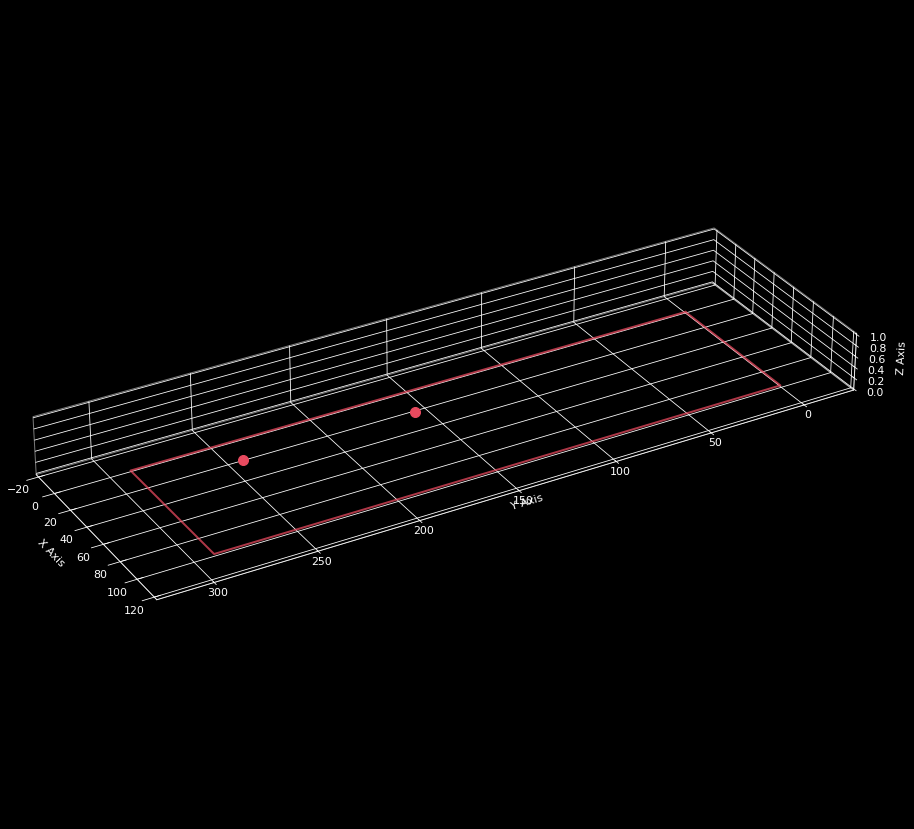

In [35]:
fig, ax = create_blank_chart_with_styling(
    x_range=(TARGET_WIDTH + PADDING, -PADDING),
    y_range=(-PADDING, TARGET_HEIGHT + PADDING),
    z_range=(0, 1),
    size=(15, 15)
)

ax.plot([0, 99, 99, 0, 0],[0, 0, 290, 290, 0],[0, 0, 0, 0, 0], color="#e84a5f", label="RoI", lw=2, alpha=0.75)

ax.scatter([22.22],[155.97],[0], s=100, c="#e84a5f")
ax.scatter([20.061],[242.83],[0], s=100, c="#e84a5f")

# Rotating the chart
ax.view_init(30, 150)
fig.savefig('3d_vizualization.png')